<a href="https://colab.research.google.com/github/mart-anthony-stark/Machine-Learning-Daily-from-Scratch/blob/main/Wine_Reviews_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [31]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])

In [32]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [33]:
df =df.dropna(subset=['description', 'points'])

In [34]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


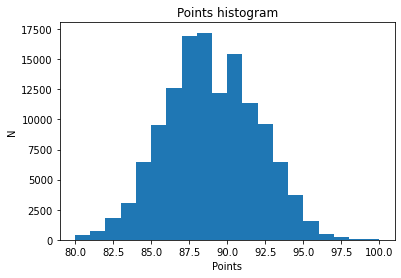

In [35]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [36]:
df["label"] = (df.points >= 90).astype(int)
df = df[['description', 'points','label']]

In [39]:
df.head()

,description,points,label
0,"Aromas include tropical fruit, broom, brimston...",87,0
1,"This is ripe and fruity, a wine that is smooth...",87,0
2,"Tart and snappy, the flavors of lime flesh and...",87,0
3,"Pineapple rind, lemon pith and orange blossom ...",87,0
4,"Much like the regular bottling from 2012, this...",87,0


### Splitting training data and validation data

In [40]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [41]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [43]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label') # target
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [44]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

## Embedding + Model
### nnlm-en-dim50
Token based text embedding trained on English Google News 7B corpus.

In [45]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [48]:
# Transformed text into vector of numbers for the model to understand
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.41691396, -0.21040307, -0.11966962, ...,  0.10890358,
         0.15431839, -0.08482464],
       [ 0.24052373, -0.10584494,  0.07657898, ..., -0.0721566 ,
        -0.21858299,  0.08648967],
       [ 0.4151127 , -0.36791524, -0.08613624, ..., -0.0628197 ,
        -0.03065088, -0.11706799],
       ...,
       [ 0.46040702, -0.2839041 , -0.14339213, ..., -0.11733786,
        -0.2133258 , -0.10315704],
       [ 0.6192024 , -0.28085887,  0.17796382, ..., -0.00116768,
        -0.26528215,  0.08520569],
       [ 0.25418505, -0.36866215, -0.22326823, ..., -0.01018733,
        -0.12705621,  0.05996499]], dtype=float32)>

In [49]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [51]:
model.evaluate(train_data)

102/102 [==============================] - 4s 18ms/step - loss: 0.7160 - accuracy: 0.4364


[0.7159531712532043, 0.4363507032394409]

In [52]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 19ms/step - loss: 0.7170 - accuracy: 0.4356


[0.7169618606567383, 0.43563899397850037]

In [53]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 56s 529ms/step - loss: 0.5577 - accuracy: 0.7072 - val_loss: 0.4184 - val_accuracy: 0.8056
Epoch 2/5
102/102 [==============================] - 54s 526ms/step - loss: 0.3706 - accuracy: 0.8309 - val_loss: 0.3770 - val_accuracy: 0.8257
Epoch 3/5
102/102 [==============================] - 55s 541ms/step - loss: 0.3266 - accuracy: 0.8554 - val_loss: 0.3755 - val_accuracy: 0.8295
Epoch 4/5
102/102 [==============================] - 54s 532ms/step - loss: 0.3032 - accuracy: 0.8675 - val_loss: 0.3723 - val_accuracy: 0.8297
Epoch 5/5
102/102 [==============================] - 60s 588ms/step - loss: 0.2848 - accuracy: 0.8774 - val_loss: 0.3761 - val_accuracy: 0.8293


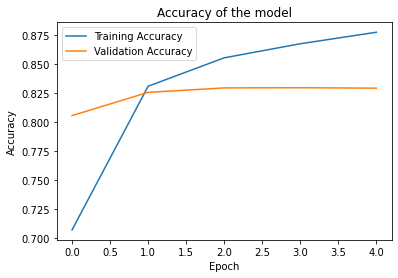

In [56]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

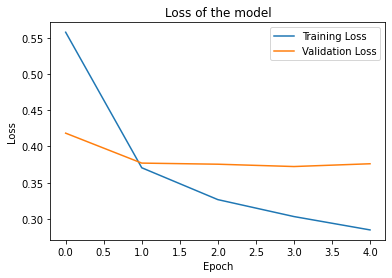

In [57]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss of the model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()